We will import the UTCDateTime function as well as a Client to grab data.

In [1]:
from obspy.core import UTCDateTime
from obspy.clients.fdsn import Client

Pick a network, station, location, and channel (SNCL) along with starttime and an endtime.

You can always go to [IRIS MDA](http://ds.iris.edu/mda/) to find stations/networks/information

You can find more about SNCLs and the various codes in [Ringler and Evans (2015)](https://github.com/aringler-usgs/IRIS_2022/blob/main/SEED_Tutorial.pdf).


In [2]:
net, sta, loc, chan = 'IU', 'KIP', '00', 'LHZ'
stime = UTCDateTime('2022-01-15T00:00:00')
etime = stime + 20*60*60
client = Client('IRIS')

Using the MDA, where is the station above located? What type of seismometer is it?

Now we should grab some data and print out to see what we have.

In [3]:
st = client.get_waveforms(net, sta, loc, chan, stime, etime)
print(st)

1 Trace(s) in Stream:
IU.KIP.00.LHZ | 2022-01-15T00:00:00.069538Z - 2022-01-15T19:59:59.069538Z | 1.0 Hz, 72000 samples


What are the units of the data we get?

When you run into a programming issue what should you do? [Google!](https://letmegooglethat.com/?q=Plot+an+obspy+stream)

Okay we should plot the data to see what we got.

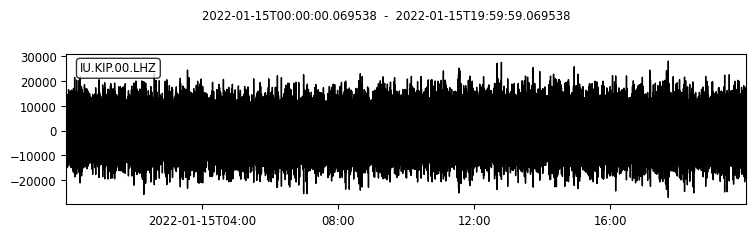

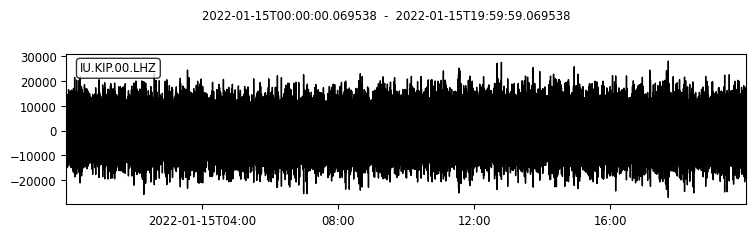

In [4]:
st.plot()

Why don't we turn this data into something useful?  Perhaps we should convert to velocity.

We need to get the metadata for that.

In [5]:
    inv = client.get_stations(network=net, starttime=stime, 
            endtime = stime + 60*60*60, level="response", 
            location=loc, channel=chan, station=sta)

What are net, sta, loc, and chan?  Where did we define them?

What is in the inventory?

In [6]:
print(inv)

Inventory created at 2022-05-25T13:03:29.901000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.48
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2022-01-15...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			IU
		Stations (1):
			IU.KIP (Kipapa, Hawaii, USA)
		Channels (1):
			IU.KIP.00.LHZ


What if we wanted to grab more than just one channel?

We can "wildcard things using the "*".  

In [7]:
    inv = client.get_stations(network=net, starttime=stime, 
            endtime = stime + 60*60*60, level="response", 
            location=loc, channel='L*', station=sta)
    
    print(inv)

Inventory created at 2022-05-25T13:03:30.168000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.48
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2022-01-15...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			IU
		Stations (1):
			IU.KIP (Kipapa, Hawaii, USA)
		Channels (3):
			IU.KIP.00.LHZ, IU.KIP.00.LH1, IU.KIP.00.LH2


Okay we have metadata and we have data so we should remove the response and convert to velocity.  First we should look at the response.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


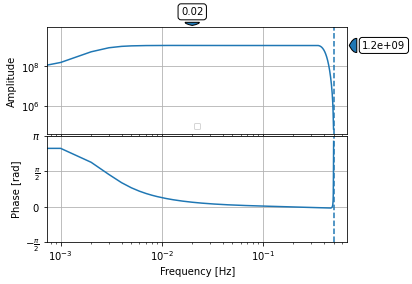

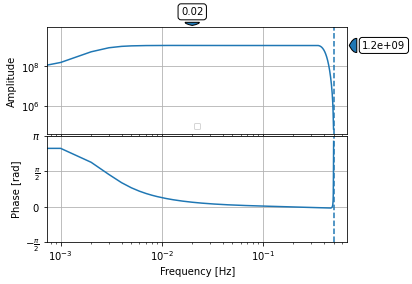

In [8]:
inv[0][0][0].response.plot(0.001, output="VEL")  

So we want to invert this from our data.  The details don't matter too much, you just remove it via obsPy.

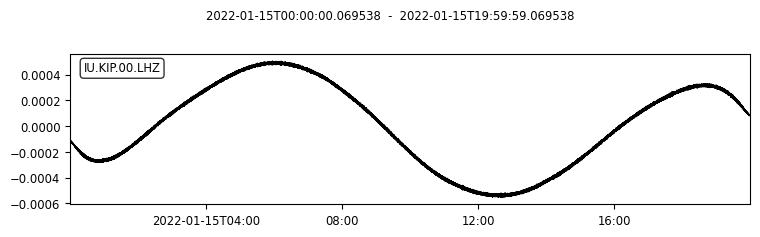

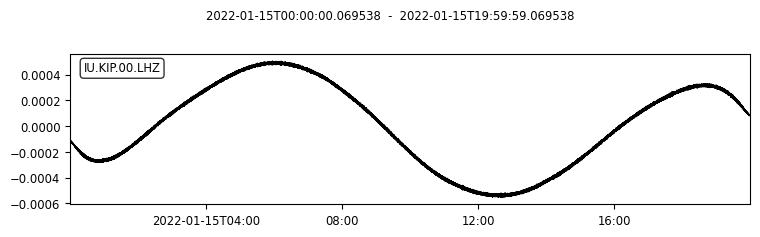

In [9]:
st.remove_response(inventory=inv, output='VEL')

st.plot()

Hmm, what are these big semi-diurnal/diurnal signals?  

Any guesses?

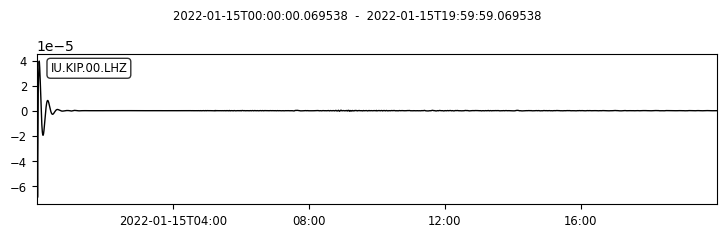

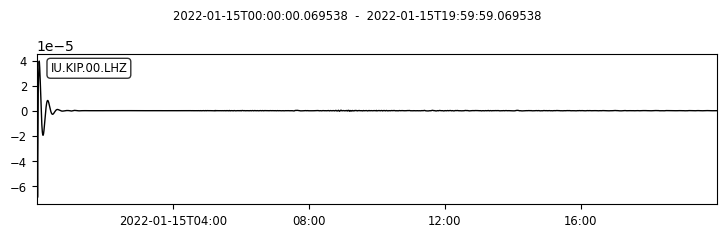

In [10]:
st2 = st.copy()

st.filter('bandpass', freqmin=0.001, freqmax=0.01)
st.plot()

Uh oh we have filter ringing.  Basically where the filter produces large values at the beginning of our time series.  To get rid of this we can trim the data.

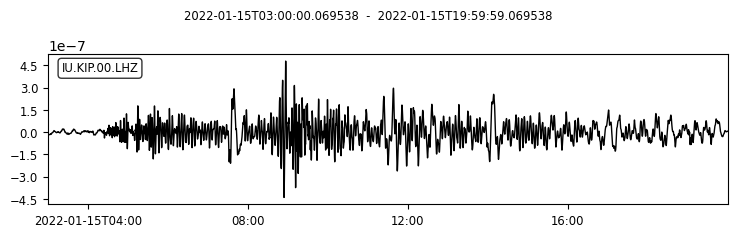

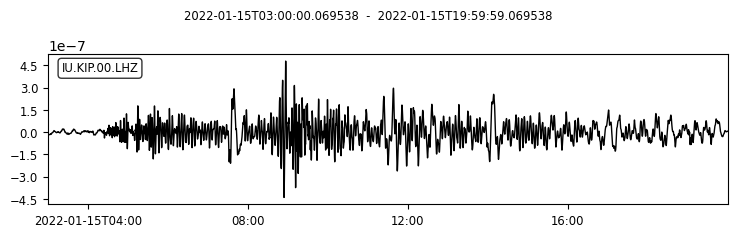

In [11]:
st.trim(st[0].stats.starttime+3*60*60)
st.plot()

Well this is more interesting than what we intially saw.  Notice the vertical axis numbers are much smaller.

Any guess what this is?

Hint: Google seismic event Janary 15, 2022 ;)

Extra credit: We know that the seismic signal travels faster than the acoustic (pressure) signal.  Assuming 3 km/s seismic speed and 350 m/s acoustic can you estimate the distance of the event?  

Hint: Use the start time of the initial pulse at 04:40 and the acoustic pulse at around 09:00 to estimate the event.

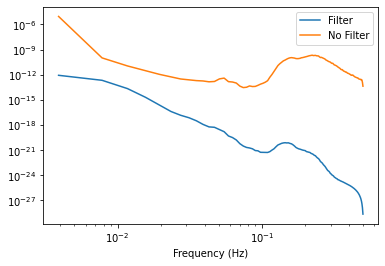

In [12]:
from matplotlib.pyplot import psd
import matplotlib.pyplot as plt

p1, f = psd(st[0].data, Fs=1)
p2, _ = psd(st2[0].data, Fs=1)
f = f[1:]
p1 = p1[1:]
p2 = p2[1:]
                
fig = plt.figure(1)
plt.clf()
plt.loglog(f,p1,label='Filter')
plt.loglog(f,p2, label='No Filter')
plt.xlabel('Frequency (Hz)')
plt.legend()

Notice that the filter basically attenuates out a portion of the data.  The trim makes these two PSDs different.

REVIEW:

We grabbed data from IRIS via the SNCL and times.

We used the MDA to verify things and do sanity checks.

We grabbed metadata and used it to remove the response

We applied a filter to look at data in a specific frequency band.

REMEMBER: seismologists like to look at fast things (high-frequency events), slow things (Earth tides), big things (buildings shaking), and small things (the hum of the Earth from the oceans).  So filtering is key!



Extra Credit: How did we know the acoustic pulse happened?

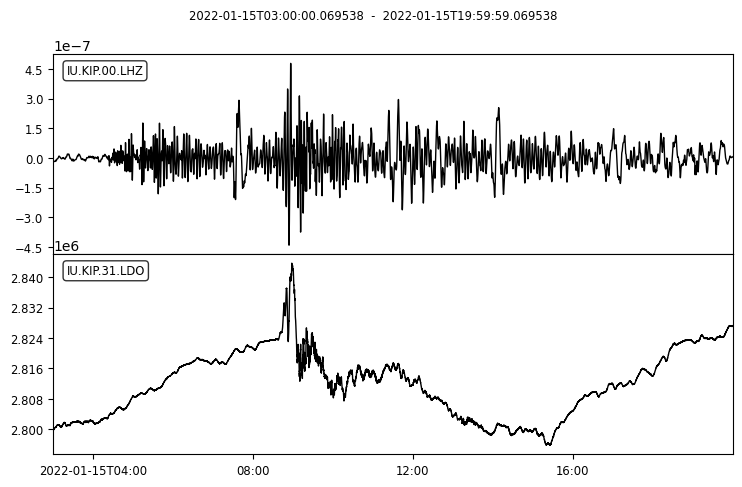

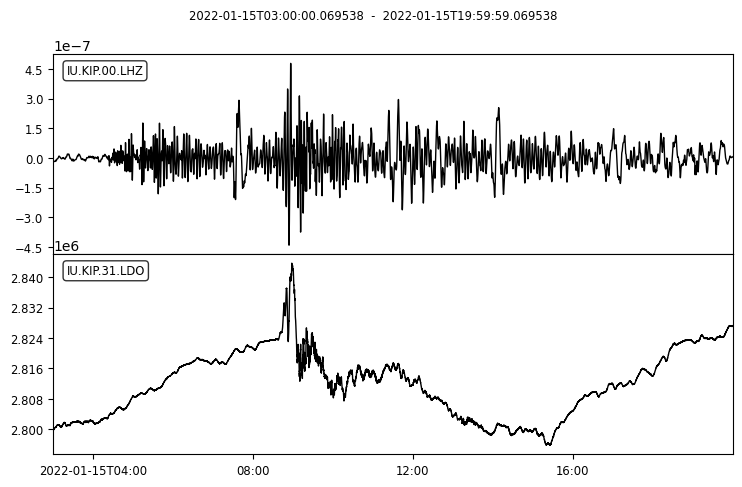

In [13]:
st += client.get_waveforms(net, sta, '31', 'LDO', st[0].stats.starttime, st[0].stats.endtime)
st.plot(equal_scale=False)

Top is seismic and bottom is pressure! Note we didn't remove the response of the pressure sensor so the bottom trace is in counts!

Extra Credit: Do this exercise with a seismic station next to your home/university.

More Extra Credit: Do this exercise and also include horizontal data.

Even More Extra Credit: Do this exercise with an earthquake.  You can find earthquakes at the [USGS](https://earthquake.usgs.gov/earthquakes/map/?extent=2.02107,-147.91992&extent=62.75473,-42.09961).  Can you find the P and S wave?  Use this to identify the distance of the event.  They travel at 8 km/s (P) and 4 km/s (S) (roughly).